### Improved SE on FER-2013

See the other notebooks for the simpler models and for the other dataset.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, ReLU, Multiply, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Enhanced train_data_gen with data augmentation; adapted from https://github.com/hujie-frank/SENet 

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # For validation data
    horizontal_flip=True,  # Random mirroring
    rotation_range=10,  # Random rotation between -10 to 10 degrees
    width_shift_range=0.08,  # Random horizontal shift, 8% of total width
    height_shift_range=0.08,  # Random vertical shift, 8% of total height
    brightness_range=[0.8, 1.2],  # Pixel jitter for brightness
    zoom_range=[0.92, 1.08],  # Random zoom, simulating cropping
    fill_mode='nearest'  # How to fill points outside the boundaries
)

train_generator = train_data_gen.flow_from_directory(
    'datasets/FER-2013/train',
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode='categorical',
    subset='training')

validation_generator = train_data_gen.flow_from_directory(
    'datasets/FER-2013/train', 
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation')

test_data_gen = ImageDataGenerator(rescale=1./255) # normalize

test_generator = test_data_gen.flow_from_directory(
    'datasets/FER-2013/test',
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1  
    filters = init.shape[channel_axis]
    
    se = GlobalAveragePooling2D()(init)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    se = Reshape((1, 1, filters))(se)
    x = Multiply()([init, se])
    return x

# Model definition, use Functional API instead of Sequential
input_img = Input(shape=(48, 48, 1))

# 1st conv block
x = Conv2D(32, kernel_size=(3, 3), padding='same')(input_img)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  

# 2nd conv block
x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# 3rd conv block
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  
x = MaxPooling2D(pool_size=(2, 2))(x)

# 4th conv block
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Additional Dense layer to increase complexity
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(7, activation='softmax')(x)

model = Model(inputs=input_img, outputs=output)


# Set up the learning rate schedule and compile the model
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


2024-03-22 01:54:58.589309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           320       ['input_1[0][0]']             
                                                                                                  
 re_lu (ReLU)                (None, 48, 48, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 32)           128       ['re_lu[0][0]']               
 Normalization)                                                                               

In [4]:
# Early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model_info = model.fit(
        train_generator,
        steps_per_epoch=22968 // 32, # number of training data divided by batch size
        epochs=80,
        validation_data=validation_generator,
        validation_steps=5741 // 32,
        callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/80


2024-03-22 01:55:02.485435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-22 01:55:03.508175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-22 01:55:04.371397: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1215379e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 01:55:04.371441: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-03-22 01:55:04.379730: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 01:55:04.596876: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

717/717 [==============================] - 64s 75ms/step - loss: 2.7066 - accuracy: 0.2070 - val_loss: 1.9376 - val_accuracy: 0.3083
Epoch 2/80
717/717 [==============================] - 41s 57ms/step - loss: 2.3007 - accuracy: 0.2481 - val_loss: 1.6923 - val_accuracy: 0.3541
Epoch 3/80
717/717 [==============================] - 39s 54ms/step - loss: 2.0845 - accuracy: 0.2864 - val_loss: 1.6185 - val_accuracy: 0.3769
Epoch 4/80
717/717 [==============================] - 39s 55ms/step - loss: 1.9256 - accuracy: 0.3179 - val_loss: 1.5871 - val_accuracy: 0.3900
Epoch 5/80
717/717 [==============================] - 38s 53ms/step - loss: 1.7979 - accuracy: 0.3515 - val_loss: 1.5761 - val_accuracy: 0.4089
Epoch 6/80
717/717 [==============================] - 40s 55ms/step - loss: 1.7040 - accuracy: 0.3734 - val_loss: 1.5058 - val_accuracy: 0.4326
Epoch 7/80
717/717 [==============================] - 38s 53ms/step - loss: 1.6087 - accuracy: 0.4056 - val_loss: 1.5830 - val_accuracy: 0.4282
Epo

- early stopping at 52/80, best epoch 47, accuracy 63%

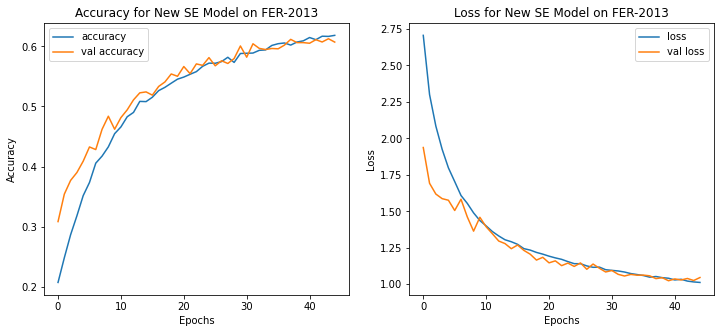

In [5]:
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

plt.figure(figsize=(12, 5))

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy for New SE Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss for New SE Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [6]:
results = model.evaluate(test_generator, steps=len(test_generator))

# Test results
print("Test loss:", results[0])
print("Test accuracy:", results[1])

225/225 [==============================] - 11s 48ms/step - loss: 1.0031 - accuracy: 0.6237
Test loss: 1.0031490325927734
Test accuracy: 0.623711347579956


1/1 [==============================] - 0s 28ms/step


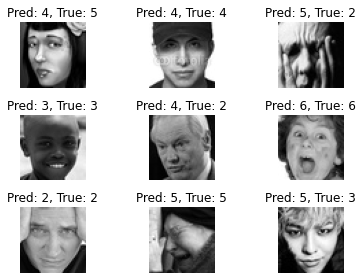

In [9]:
# Get a batch of images and labels from the test generator
x_batch, y_batch = next(test_generator)

# Make predictions on this batch
predictions = model.predict(x_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_batch, axis=1)

# Visualization
fig, axes = plt.subplots(3, 3)
axes = axes.flatten()
for i, ax in enumerate(axes):
    img = np.squeeze(x_batch[i])  # Remove channel dim if grayscale
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {predicted_classes[i]}, True: {true_classes[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()